In [2]:
import os
import numpy as np
import numpyro.distributions as dist
from jax import random
from scipy.stats import binom

import seaborn as sns
import matplotlib.pyplot as plt
# Plots
plt.style.use('seaborn-whitegrid')

# PLOT PREAMBLE: LIKE LATEX
LATEX_WIDTH = 6
LATEX_HEIGHT = 3.24

SCRIPT_SIZE = 7

#Direct input
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : SCRIPT_SIZE,
          'axes.labelsize' : SCRIPT_SIZE,
          'xtick.labelsize' : SCRIPT_SIZE,
          'ytick.labelsize' : SCRIPT_SIZE,
          'legend.fontsize' : SCRIPT_SIZE,
          'figure.titlesize' : SCRIPT_SIZE,
          'font.family' : 'serif',
          'font.serif': ['Computer Modern Roman']
          }
plt.rcParams.update(params)

## Talts et. al (2018) baseline for
- Log-normal experiment with test statistics $f_1(\theta)=\mu$, $f_2(\theta)=\sigma^2$
- Volatility experiment with test statistics $g(\theta)=\overline{\theta}$ for each approximation method

### Generating the data
Each setting gives a matrix of shape (num_samples_joint, num_samples_approx + 1, dim_data).
The test statistic is applied to every entry, which yields a matrix of shape (num_samples_joint, num_samples_approx + 1).
The rank of the first entry w.r.t. to the other entries is computed to give a vector of shape (num_samples_joint), whose histogram is plotted.


In [3]:
def ranks_from_tensor(data_tensor, statistic_fn, num_rebins=0):
    """Generates array of ranks from a data tensor of Talts et. al (2018).
    Input:
        data_tensor (np.array): shape (num_samples_joint, num_samples_approx + 1, dim_data). First dimension is independent repititions over the Bayesion model, second dimensions are samples from the approximation and as first entry the prior sample, and last dimension are the latent vectors.
        statistic_fn (function): summary statistic that is applied to every latent vector before computing ranks.
        num_rebins (integer): Number of times the resulting ranks are rebinned. Every rebinning halfs the ranks.
    Output:
        ranks (np.array): rank vectors
    """
    num_joint, num_samples, dim_data = data_tensor.shape

    # Apply summary statistic
    data_statistics = np.zeros((num_joint, num_samples))
    for i in range(num_joint):
        for j in range(num_samples):
            data_statistics[i, j] = statistic_fn(data_tensor[i, j, :])

    # Compute ranks
    ranks = np.zeros(num_joint)
    for i in range(num_joint):
        # Using argsort twice gives rank of the respective position
        ranks[i] = np.argsort(np.argsort(data_statistics[i, :]))[0]
    # Rebinning (merge ranks (i, i+1) -> i, (i+2, i+3) -> i+2, ....)
    assert (num_samples+1) % 2**num_rebins == 0, "num_samples+1 needs to be divisible by 2^num_rebins."
    while num_rebins > 0:
        ranks = np.floor(ranks/2).astype(int)
        num_rebins -= 1
    return ranks

In [4]:
def generate_noisy_tensor(num_joint, num_samples, dim_data):
    """Placeholder for real Markov chains."""
    return np.random.normal(loc=0, scale=1, size=(num_joint, num_samples, dim_data))

# Load the data in data_tensors: [num_joint, num_samples, dim_data]
data_dict = {'log_normal' : np.load(f'../res/abc/baseline/baseline.npy')[:, :31, :],
             'volatility_nuts_long' : np.load('../res/volatility/baseline/baseline_mcmc_long.npy')[:, :31, :],
             'volatility_nuts_short' : np.load('../res/volatility/baseline/baseline_mcmc_short.npy')[:, :31, :],
             'volatility_vb_full' : np.load('../res/volatility/baseline/baseline_vb_full.npy')[:, :31, :],
             'volatility_vb_diag' : np.load('../res/volatility/baseline/baseline_vb_diag.npy')[:, :31, :]}
# for key in data_dict.keys():
#     dim_data = 2 if key=='log_normal' else 100
#     data_dict[key] = generate_noisy_tensor(num_joint=500, num_samples=20, dim_data=dim_data)

# Compute rank arrays
num_rebins = 1
rank_dict = {'ln_mu' : ranks_from_tensor(data_tensor=data_dict['log_normal'], statistic_fn=lambda x:x[0], num_rebins=num_rebins),
             'ln_sigma' : ranks_from_tensor(data_tensor=data_dict['log_normal'], statistic_fn=lambda x:x[1], num_rebins=num_rebins),
             'vol_long' : ranks_from_tensor(data_tensor=data_dict['volatility_nuts_long'], statistic_fn=lambda x:np.mean(x), num_rebins=num_rebins),
             'vol_short' : ranks_from_tensor(data_tensor=data_dict['volatility_nuts_short'], statistic_fn=lambda x:np.mean(x), num_rebins=num_rebins),
             'vol_full' : ranks_from_tensor(data_tensor=data_dict['volatility_vb_full'], statistic_fn=lambda x:np.mean(x), num_rebins=num_rebins),
             'vol_diag' : ranks_from_tensor(data_tensor=data_dict['volatility_vb_diag'], statistic_fn=lambda x:np.mean(x), num_rebins=num_rebins)}

def get_quantiles(N, L, lower_quant, upper_quant):
    """Computes quantiles of the Bin(N, (L+1)^{-1}) distribution for confidence band of rank statistics."""
    lower = binom.ppf(q=lower_quant, n=N, p=1/(L+1))
    upper = binom.ppf(q=upper_quant, n=N, p=1/(L+1))
    return lower, upper

### Larger plots: every method + summary statistic gets their own plot

In [8]:
print(data_dict['log_normal'].shape)

(323, 31, 2)


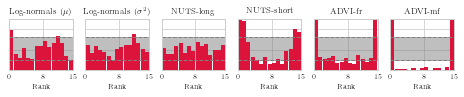

In [7]:
col_hist='crimson'
N = data_dict['log_normal'].shape[0]
L = (data_dict['log_normal'].shape[1] - 1) / 2 ** num_rebins
bins = np.arange(L+1)
xlims = (0, L)
conf_linewidth = 1
lower_conf, upper_conf = get_quantiles(N, L, lower_quant=.005, upper_quant=.995)

method_names = {'ln_mu' : r'Log-normals ($\mu$)',
                'ln_sigma' : r'Log-normals ($\sigma^2$)',
                'vol_long' : 'NUTS-long',
                'vol_short' : 'NUTS-short',
                'vol_full' : 'ADVI-fr',
                'vol_diag' : 'ADVI-mf'}

methods_order = {0 : 'ln_mu',
                 1 : 'ln_sigma',
                 2 : 'vol_long',
                 3 : 'vol_short',
                 4 : 'vol_full',
                 5 : 'vol_diag'}
fig, axs = plt.subplots(nrows=1, ncols=6, sharey=True)
fig.set_size_inches(1.05* LATEX_WIDTH, .12*LATEX_WIDTH)
plt.subplots_adjust(top = .99, bottom=.01, left=.01, right=.99, hspace=.4, wspace=.2)

# Histograms
for j in range(len(rank_dict)):
    # Confidence band
    axs[j].fill_between(np.arange(xlims[0], xlims[1]+1), lower_conf, upper_conf, color='gray', alpha=.5)
    axs[j].axhline(y=lower_conf, color='gray', linestyle='--', linewidth=conf_linewidth)
    axs[j].axhline(y=upper_conf, color='gray', linestyle='--', linewidth=conf_linewidth)

    # Ranks
    method = methods_order[j]
    ranks = rank_dict[method]
    axs[j].hist(ranks, bins=bins, color=col_hist, rwidth=.95)




    # Annotation
    axs[j].set_title(method_names[methods_order[j]])
    axs[j].set_xlabel('Rank')
    axs[j].set_yticklabels([])
    axs[j].set_xlim(xlims)
    axs[j].set_xticks([0, round(L/2), L])
    axs[j].set_ylim((0, 50))


plt.savefig('../fig/baseline.pdf', bbox_inches='tight')
plt.show()